## Imports

In [ ]:
%%capture
! pip install chembl_webresource_client

In [ ]:
%%capture
! pip install rdkit

In [ ]:
%%capture
! pip install padelpy

In [ ]:
%%capture
! pip install lazypredict

In [ ]:
%%capture
! pip install torcheval

In [ ]:
from chembl_webresource_client.new_client import new_client

ModuleNotFoundError: No module named 'chembl_webresource_client'

In [ ]:
from rdkit.Chem import Descriptors, Lipinski
from rdkit import Chem

In [ ]:
from padelpy import padeldescriptor
from padelpy import from_smiles

In [ ]:
from lazypredict.Supervised import LazyRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.model_selection import KFold
import torch
from torch import nn
# from torcheval.metrics.functional import r2_score

## Get bioactivity data of the target molecule

In [ ]:
target_name = 'Glycogen synthase kinase-3 beta'

In [ ]:
# Search target
target = new_client.target
target_query = target.search(target_name).filter(organism='Homo sapiens')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Glycogen synthase kinase-3,29.0,False,CHEMBL2095188,"[{'accession': 'P49840', 'component_descriptio...",PROTEIN FAMILY,9606
1,"[{'xref_id': 'P49841', 'xref_name': None, 'xre...",Homo sapiens,Glycogen synthase kinase-3 beta,27.0,False,CHEMBL262,"[{'accession': 'P49841', 'component_descriptio...",SINGLE PROTEIN,9606
2,"[{'xref_id': 'P49840', 'xref_name': None, 'xre...",Homo sapiens,Glycogen synthase kinase-3 alpha,27.0,False,CHEMBL2850,"[{'accession': 'P49840', 'component_descriptio...",SINGLE PROTEIN,9606
3,[],Homo sapiens,Axin-1/Glycogen synthase kinase-3 beta,25.0,False,CHEMBL3883309,"[{'accession': 'P49841', 'component_descriptio...",PROTEIN-PROTEIN INTERACTION,9606
4,"[{'xref_id': 'P13807', 'xref_name': None, 'xre...",Homo sapiens,Muscle glycogen synthase,24.0,False,CHEMBL4000,"[{'accession': 'P13807', 'component_descriptio...",SINGLE PROTEIN,9606
...,...,...,...,...,...,...,...,...,...
1921,[],Homo sapiens,Secretory phospholipase A2,1.0,False,CHEMBL4524005,"[{'accession': 'Q5R387', 'component_descriptio...",PROTEIN FAMILY,9606
1922,[],Homo sapiens,P2X receptor,1.0,False,CHEMBL4524012,"[{'accession': 'P51575', 'component_descriptio...",PROTEIN FAMILY,9606
1923,[],Homo sapiens,Vasoactive intestinal peptide receptor,1.0,False,CHEMBL4524128,"[{'accession': 'P41587', 'component_descriptio...",PROTEIN FAMILY,9606
1924,[],Homo sapiens,26S proteasome,0.0,False,CHEMBL2364701,"[{'accession': 'Q99460', 'component_descriptio...",PROTEIN COMPLEX,9606


In [ ]:
selected_target = targets[targets.pref_name == target_name].target_chembl_id.iloc[0]

In [ ]:
# Get bioactivity data
activity = new_client.activity
activities = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

In [ ]:
activities =  pd.DataFrame.from_dict(activities)

In [ ]:
# Check contents
print(activities.shape)
print(activities.columns)

(4154, 46)
Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


In [ ]:
to_keep = ['molecule_chembl_id','canonical_smiles','standard_value']
activity = activities[to_keep]

## Data preprocessing

In [ ]:
# Drop rows with NaN value in standard_value or canonical_smiles columns
activity = activity.dropna(subset=['standard_value', 'canonical_smiles'])

In [ ]:
# Drop rows with duplicates of the canonical_smiles column
activity = activity.drop_duplicates(['canonical_smiles'])

In [ ]:
# Get the longest molecular component in smiles
def longest_smiles(smile_string):
  cpd = str(smile_string).split('.')
  return max(cpd, key=len)

activity['canonical_smiles'] = activity.canonical_smiles.map(longest_smiles)

In [ ]:
# Statistic description of IC50 values
activity.standard_value.describe()

,standard_value
count,3.446000e+03
mean,4.459030e+04
std,1.207456e+06
min,1.300000e-02
25%,6.000000e+01
50%,7.070000e+02
75%,1.000000e+04
max,5.000000e+07


<Axes: >

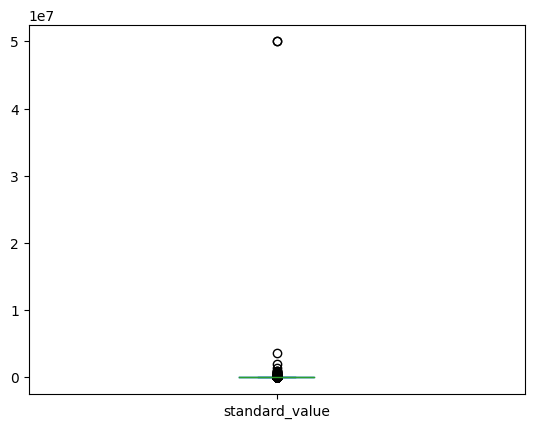

In [ ]:
# Box plot of IC50 values
activity.standard_value.plot.box()

In [ ]:
# Remove outlier
activity = activity[activity.standard_value < 5 * 10**7]

<Axes: >

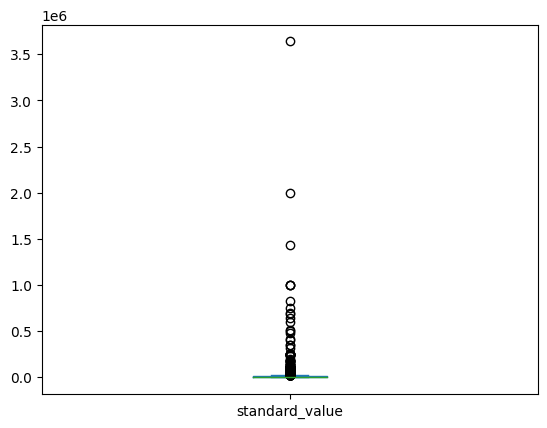

In [ ]:
# Box plot of IC50 values
activity.standard_value.plot.box()

Text(0.5, 1.0, 'Log-Scaled IC50 Histogram')

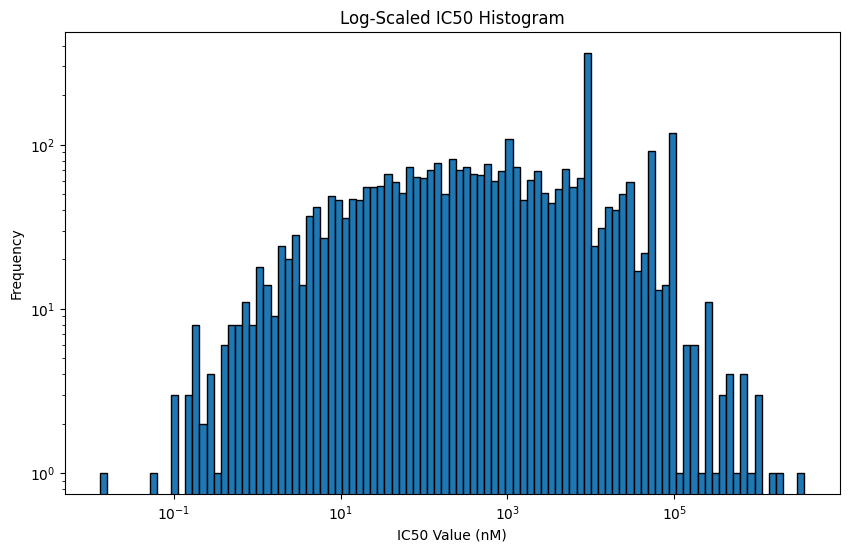

In [ ]:
# Histogram of the IC50
plt.figure(figsize=(10,6))
log_bins = np.logspace(np.log10(activity.standard_value.min()), np.log10(activity.standard_value.max()), 100)
counts, bins, patches = plt.hist(activity.standard_value, bins=log_bins ,log=True, edgecolor='black')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('IC50 Value (nM)')
plt.ylabel('Frequency')
plt.title('Log-Scaled IC50 Histogram')

### Data labelling : active, inactive or intermediate
IC50 is a unit measure of the concentration of a drug or compound required  
 to inhibit a particular biological or biochemical process by 50%.

* Active (strongly potent): IC50 < 1000 nM  
* Intermediate (moderate activity) : 1000 nM < IC50 < 10000 nM  
* Inactive : IC50 > 10000 nM  


In [ ]:
# Data labelling : active, inactive or intermediate
def activity_label(ic50):
  if ic50 < 1000:
    return 'active'
  elif ic50 > 10000:
    return 'inactive'
  else:
    return 'intermediate'

In [ ]:
activity['class'] = activity.standard_value.map(activity_label)

In [ ]:
activity.to_csv('activity_labelled.csv')

In [ ]:
activity = pd.read_csv('/content/activity_labelled.csv')

In [ ]:
activity= activity.drop(columns=['Unnamed: 0'])

In [ ]:
# Data pre-processing
activity.columns

Index(['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'class'], dtype='object')

### Comparison between active and inactive molecules with Lipinski descriptors

Lipinski's Rule of Five is a set of guidelines to evaluate the drug-likeness of a molecule based on its physicochemical properties, such as:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10


In [ ]:
def lipinski_descriptors(smiles_string):
  mol = Chem.MolFromSmiles(smiles_string)
  MolWt = Descriptors.MolWt(mol)
  MolLogP = Descriptors.MolLogP(mol)
  NumHDonors = Lipinski.NumHDonors(mol)
  NumHAcceptors = Lipinski.NumHAcceptors(mol)
  return MolWt, MolLogP, NumHDonors, NumHAcceptors

activity['MolWt'], activity['MolLogP'], activity['NumHDonors'], \
activity['NumHAcceptors'] = zip(*activity.canonical_smiles.map(lipinski_descriptors))

In [ ]:
# Convert IC50 to pIC50 to allow a more uniform distribution
def pic50(ic50):
  # Values greater than 10**8 will be fixed at 10**8,
  # otherwise the negative logarithmic value will become negative.
  if ic50 > (10**8):
    ic50 = 10**8
  # Convert IC50 which is in nM to M
  m = ic50 * (10**-9)
  # Convert IC50 to negative log scale
  return -np.log10(m)

activity['pIC50'] = activity.standard_value.map(pic50)

In [ ]:
activity.pIC50.describe()

,pIC50
count,3444.000000
mean,6.219160
std,1.356458
min,2.438899
25%,5.000000
50%,6.153665
75%,7.223674
max,10.886057


In [ ]:
# Filter out the intermediate class
no_inter = activity[activity['class'] != 'intermediate']

Text(0, 0.5, 'Frequency')

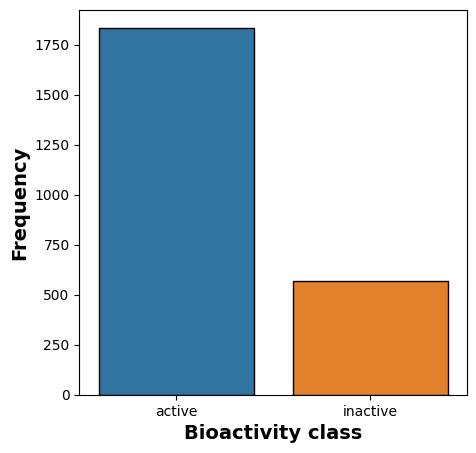

In [ ]:
# Frequency plot of active and inactive class
plt.figure(figsize=(5,5))
sns.countplot(x='class', data=no_inter, edgecolor='black', hue='class')
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

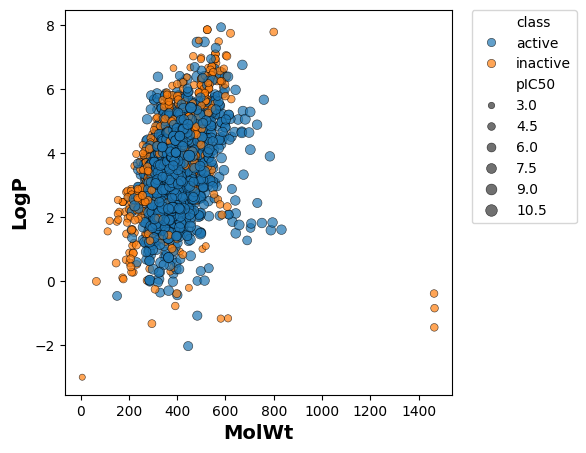

In [ ]:
# Scatter plot of MW and LogP
plt.figure(figsize=(5,5))
sns.scatterplot(x='MolWt', y='MolLogP', data=no_inter, hue='class', size='pIC50',
                edgecolor='black', alpha=0.7)
plt.xlabel('MolWt', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

#### Does the Lipinski descriptors differ significantly between the active and inactive groups?

In [ ]:
def mannwhitney(descriptor, alpha=0.05):
  np.random.seed(42)
  # Get the chosen descriptor for the active and inactive class
  active = activity[activity['class'] == 'active'][descriptor]
  inactive = activity[activity['class'] == 'inactive'][descriptor]

  # Compute P-value
  stat, p = mannwhitneyu(active,inactive)

  # Interpret
  if p > alpha :
    print(f'P-value : {p}\nSame distribution (fail to reject H0)')
  else :
    print(f'P-value : {p}\nDifferent distribution (reject H0)')

##### pIC50

Text(0, 0.5, 'pIC50 value')

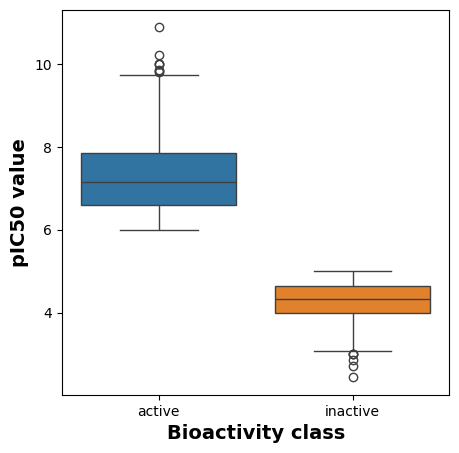

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='class', y='pIC50', data=no_inter, hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('pIC50')

P-value : 2.0539334364424757e-284
Different distribution (reject H0)


##### MolWt

Text(0, 0.5, 'MolWt')

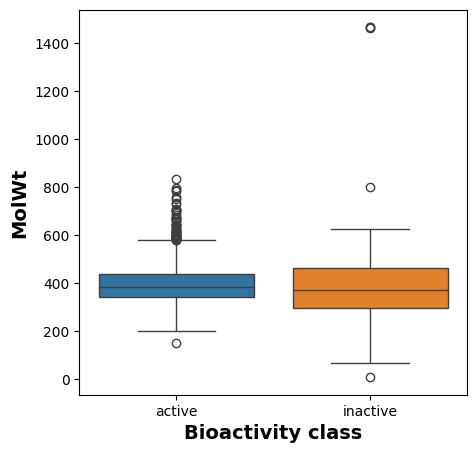

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='class', y='MolWt', data=no_inter, hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MolWt', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('MolWt')

P-value : 0.0005395054304596096
Different distribution (reject H0)


##### LogP

Text(0, 0.5, 'MolLogP')

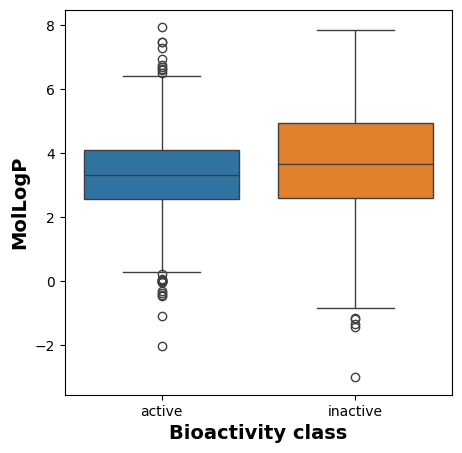

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='class', y='MolLogP', data=no_inter, hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MolLogP', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('MolLogP')

P-value : 4.503430865199676e-08
Different distribution (reject H0)


##### NumHDonors


Text(0, 0.5, 'NumHDonors')

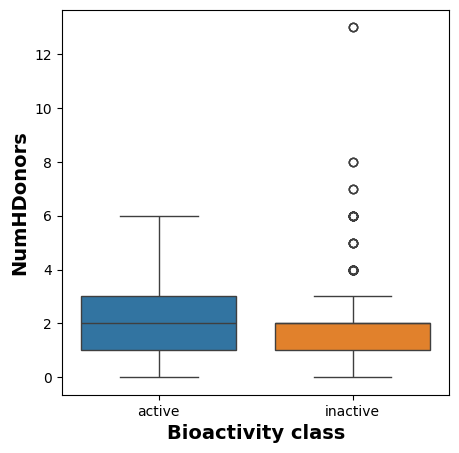

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(x='class', y='NumHDonors', data=no_inter, hue='class')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

In [ ]:
mannwhitney('NumHDonors')

P-value : 7.08795391086913e-05
Different distribution (reject H0)


The classication of molecules by thresholding:
* Active (strongly potent): IC50 < 1000 nM
* Inactive : IC50 > 10000 nM  

are reflected in the 4 Lipinski's descriptor which have statistically significant difference between the actives and inactives.

### Calculate Fingerprint Descriptors

In [ ]:
# Create SMILES file
smi = activity[['canonical_smiles', 'molecule_chembl_id']]
smi.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
padeldescriptor(mol_dir='molecule.smi',
                d_file='fingerprint_output.csv',
                standardizenitro=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [ ]:
X = pd.read_csv('fingerprint_output.csv')

In [ ]:
X = pd.read_csv('X.csv')

In [ ]:
X = X.drop(columns=['Unnamed: 0'])

In [ ]:
X.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train.shape

(2755, 155)

In [ ]:
X = X.drop(columns=['Name'])

KeyError: "['Name'] not found in axis"

In [ ]:
y = activity['pIC50']

In [ ]:
X.shape, y.shape

((3444, 881), (3444,))

In [ ]:
# Remove low variance features
selection = VarianceThreshold(threshold=(0.8 * (1 - 0.8)))
X = selection.fit_transform(X)

In [ ]:
X.shape

(3444, 154)

In [ ]:
# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Create and Train Model


### Base Model

In [ ]:
# Define the regression models
reg = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None,
                    random_state=42)

# # Cross-validation
# kf = KFold(n_splits=5)
# results = []
# for (train_index, test_index) in kf.split(X):
#   # Split the data train and test set
#   X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
#   models, predictions = reg.fit(X_train, X_test, y_train, y_test) # Train
#   top_5 = models.iloc[:5]
#   results.append(top_5) # Save top 5 result

In [ ]:
models,predictions = reg.fit(X_train, X_test, y_train, y_test)

 98%|█████████▊| 41/42 [00:41<00:00,  1.68it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 462
[LightGBM] [Info] Number of data points in the train set: 2755, number of used features: 154
[LightGBM] [Info] Start training from score 6.225257


100%|██████████| 42/42 [00:41<00:00,  1.00it/s]


In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.50,0.61,0.87,1.39
RandomForestRegressor,0.47,0.59,0.90,5.05
SVR,0.47,0.59,0.90,1.65
XGBRegressor,0.46,0.58,0.90,0.37
LGBMRegressor,0.46,0.58,0.90,0.31
NuSVR,0.45,0.57,0.91,0.87
BaggingRegressor,0.42,0.55,0.94,0.50
MLPRegressor,0.39,0.53,0.96,7.02
GradientBoostingRegressor,0.37,0.51,0.97,1.41


## Hyperparameter Tuning


In [ ]:
# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
input_features = X.shape[1]
categorical_features = np.ones(X.shape[1], dtype=bool)

In [ ]:
# Define model
model = HistGradientBoostingRegressor(categorical_features=categorical_features,
                                      early_stopping=True, validation_fraction=0.1
                                      , random_state=42)

# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.07,0.08,0.09],
    'max_iter': [300],
    'min_samples_leaf': [9,10,12],
    'max_features' : [0.1,0.2,0.3],
}

In [ ]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=HistGradientBoostingRegressor(categorical_features=array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True...
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True]),
                                                     early_stopping=True,
                                                     random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.07, 0.08, 0.09],
                         'max_features': [0.1, 0.2, 0.3], 'max_iter': [300],
                         'min_samples_leaf': [9, 10, 12]},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Cross validation RMSE:", best_score)

# Evaluate on the train set
train_rmse = mean_squared_error(y_train, best_model.predict(X_train), squared=False)
train_r2 = r2_score(y_train, best_model.predict(X_train))
print("Train RMSE:", train_rmse)
print("Train R-squared:", train_r2)

# Evaluate on the test set
test_rmse = mean_squared_error(y_test, best_model.predict(X_test), squared=False)
test_r2 = r2_score(y_test, best_model.predict(X_test))
print("Test RMSE:", test_rmse)
print("R-squared:", test_r2)

Best Parameters: {'learning_rate': 0.08, 'max_features': 0.2, 'max_iter': 300, 'min_samples_leaf': 10}
Best Cross validation RMSE: 0.8316207831558866


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Train RMSE: 0.5586051957596423
Train R-squared: 0.8291098809937957
Test RMSE: 0.899216289455013
R-squared: 0.5874358138504187


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Multi-Layer Perceptron (MLP)

In [ ]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
X_torch = torch.from_numpy(X).type(torch.float32).to(device)
y_torch = torch.tensor(y.values).type(torch.float32).to(device)

In [ ]:
# add a dimension to y_torch
y_torch = y_torch.unsqueeze(dim=1)

In [ ]:
# Split to train and test set
X_train, X_test, y_train, y_test = train_test_split(X_torch, y_torch, test_size=0.2)

In [ ]:
# Parameters
input_features = X_train.shape[1]
output_features = 1
hidden_units = 2
epochs = 1000

In [ ]:
class mlp(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units**8),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units**8, out_features=hidden_units**7),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units**7, out_features=hidden_units**6),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units**6, out_features=hidden_units**5),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units**5, out_features=output_features)
    )
  def forward(self, x):
    return self.layers(x)

mlp_model =  mlp(input_features=input_features, output_features=output_features
                 , hidden_units=hidden_units)

In [ ]:
# Define RMSE Loss
def RMSELoss(yhat, y):
  return torch.sqrt(torch.mean((yhat-y)**2))

# Define Optimizer
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)

In [ ]:
torch.manual_seed(42)

# Train the model
for epoch in range(epochs):
  mlp_model.train()
  y_pred = mlp_model(X_train)
  # y_pred = torch.squeeze(y_pred)
  # Calculate RMSE
  loss = RMSELoss(y_pred, y_train)
  # Calculate R-squared score
  r2 = r2_score(y_pred, y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Test the model for the current epoch
  mlp_model.eval()
  with torch.inference_mode():
    test_pred = mlp_model(X_test)
    # test_pred = torch.squeeze(test_pred)
    test_loss = RMSELoss(test_pred, y_test)
    r2_test = r2_score(test_pred, y_test)

  if epoch % 5 == 0:
    print(f"Epoch: {epoch} | RMSE: {loss:.5f}, R-squared: {r2:.2f} | Test RMSE: {test_loss:.5f}, R-squared: {r2_test:.2f}")


Epoch: 0 | RMSE: 3.36710, R-squared: -5.10 | Test RMSE: 7.24893, R-squared: -28.98
Epoch: 5 | RMSE: 3.51880, R-squared: -5.66 | Test RMSE: 3.36417, R-squared: -5.46
Epoch: 10 | RMSE: 3.32497, R-squared: -4.95 | Test RMSE: 3.33932, R-squared: -5.36
Epoch: 15 | RMSE: 3.26542, R-squared: -4.74 | Test RMSE: 3.29416, R-squared: -5.19
Epoch: 20 | RMSE: 3.19471, R-squared: -4.49 | Test RMSE: 3.21921, R-squared: -4.91
Epoch: 25 | RMSE: 3.07997, R-squared: -4.10 | Test RMSE: 3.09607, R-squared: -4.47
Epoch: 30 | RMSE: 2.79777, R-squared: -3.21 | Test RMSE: 2.78369, R-squared: -3.42
Epoch: 35 | RMSE: 2.33819, R-squared: -1.94 | Test RMSE: 2.46638, R-squared: -2.47
Epoch: 40 | RMSE: 2.11803, R-squared: -1.41 | Test RMSE: 2.46866, R-squared: -2.48
Epoch: 45 | RMSE: 2.12210, R-squared: -1.42 | Test RMSE: 2.05427, R-squared: -1.41
Epoch: 50 | RMSE: 1.95534, R-squared: -1.06 | Test RMSE: 1.77786, R-squared: -0.80
Epoch: 55 | RMSE: 1.72964, R-squared: -0.61 | Test RMSE: 1.84791, R-squared: -0.95
Epoch